<a href="https://colab.research.google.com/github/Imeldap12/Trafa/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download File

pada tahapan ini kita melakukan download file menggunakan periintah `!gdown` untuk mendownload file yang di share melalui google dirve setelah itu dilakukan ekstrak file zip

In [ ]:
# Data 2
# https://drive.google.com/file/d/1pN7dr3rlXqxTkEnrshdkoa_zDo-A6l8p/view?usp=share_link
!gdown 1pN7dr3rlXqxTkEnrshdkoa_zDo-A6l8p -O data.zip

Downloading...
From: https://drive.google.com/uc?id=1pN7dr3rlXqxTkEnrshdkoa_zDo-A6l8p
To: /content/data.zip
100% 99.9M/99.9M [00:04<00:00, 22.6MB/s]


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: DATASET/Batik Betawi/
  inflating: DATASET/Batik Betawi/0.jpg  
  inflating: DATASET/Batik Betawi/1.jpg  
  inflating: DATASET/Batik Betawi/10.jpg  
  inflating: DATASET/Batik Betawi/11.jpg  
  inflating: DATASET/Batik Betawi/12.jpg  
  inflating: DATASET/Batik Betawi/13.jpg  
  inflating: DATASET/Batik Betawi/14.jpg  
  inflating: DATASET/Batik Betawi/15.jpg  
  inflating: DATASET/Batik Betawi/16.jpg  
  inflating: DATASET/Batik Betawi/17.jpg  
  inflating: DATASET/Batik Betawi/18.jpg  
  inflating: DATASET/Batik Betawi/19.jpg  
  inflating: DATASET/Batik Betawi/2.jpg  
  inflating: DATASET/Batik Betawi/20.jpg  
  inflating: DATASET/Batik Betawi/21.jpg  
  inflating: DATASET/Batik Betawi/22.jpg  
  inflating: DATASET/Batik Betawi/23.jpg  
  inflating: DATASET/Batik Betawi/24.jpg  
  inflating: DATASET/Batik Betawi/25.jpg  
  inflating: DATASET/Batik Betawi/26.jpg  
  inflating: DATASET/Batik Betawi/27.jpg  
  inflating: DATASET/Batik Betawi/28.jpg  
  i

# Check Corrupt image
pada tahap ini file gambar yang didapatkan di filter sehingga menemukan file  gambar yang corupt

In [ ]:
import os
from PIL import Image
folder_path = '/content/kain tradisional'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        if not filee == '.ipynb_checkpoints':
          im = Image.open(file_path)
          rgb_im = im.convert('RGB')
          if filee.split('.')[1] not in extensions:
              extensions.append(filee.split('.')[1])
print('done')

done


# Split File
dengan menggunakan modul split-floders 

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/DATASET', output="/content/splitfile", seed=1, ratio=(0.8,0.2), group_prefix=None)

Copying files: 1743 files [00:00, 6872.28 files/s]


# Preprocesing
adalah tahap yang dilakukan untuk memperbanyak data gambar dengan menggunakan imagedatagenerator

In [ ]:
import os

In [ ]:
base_dir = '/content/splitfile'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
lenClass = len(os.listdir(validation_dir))
print(lenClass)

15


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
  
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    vertical_flip=True,
                    rotation_range=20,
                    shear_range=0.2,
                    zoom_range=0.3,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    )
  
test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
sizeImg = (224, 224)
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        target_size=sizeImg)
  
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        target_size=sizeImg)

Found 1389 images belonging to 15 classes.
Found 354 images belonging to 15 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.95):
      self.model.stop_training = True
      print("\nAkurasi telah mencapai >90%!")
callbacks = myCallback()

# Making Model

In [ ]:
from tensorflow.keras.layers import Input

## Model 1
model menggunakan MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobile_net_layers = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

mobile_net_layers.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
def scheduler(epoch, lr):
  if epoch <= 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
neural_net = tf.keras.Sequential([
  mobile_net_layers,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(lenClass, activation='softmax')
])

In [ ]:
neural_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 2,423,887
Trainable params: 165,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
neural_net.compile(
    optimizer=tf.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])

In [ ]:
model_fit = neural_net.fit(train_generator, 
                          epochs=35,
                          # steps_per_epoch=1050//30,
                          # validation_steps=300//30,
                          shuffle=True, 
                          validation_data=validation_generator,
                          callbacks=[lr_callback, callbacks])

Epoch 1/35
44/44 [==============================] - 36s 533ms/step - loss: 1.9027 - accuracy: 0.4161 - val_loss: 0.8648 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 2/35
44/44 [==============================] - 24s 551ms/step - loss: 0.8755 - accuracy: 0.7070 - val_loss: 0.6425 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 3/35
44/44 [==============================] - 23s 531ms/step - loss: 0.6787 - accuracy: 0.7689 - val_loss: 0.4877 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 4/35
44/44 [==============================] - 23s 508ms/step - loss: 0.5417 - accuracy: 0.8179 - val_loss: 0.5291 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 5/35
44/44 [==============================] - 24s 537ms/step - loss: 0.5274 - accuracy: 0.8279 - val_loss: 0.4939 - val_accuracy: 0.8249 - lr: 0.0010
Epoch 6/35
44/44 [==============================] - 24s 553ms/step - loss: 0.4881 - accuracy: 0.8387 - val_loss: 0.4615 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 7/35
44/44 [==============================] - 23s 521ms/st

### Plot Model 1
dilakukan untuk mengetahui pebedaan akurasi dan loss pada data traning dan testing

In [ ]:
import matplotlib.pyplot as plt

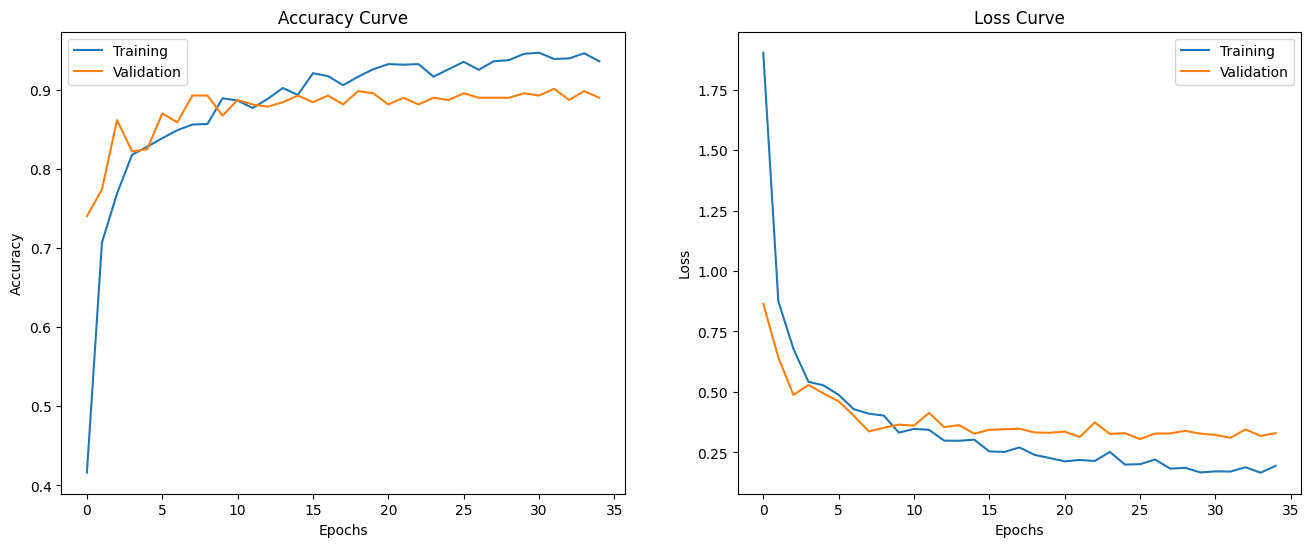

In [ ]:
train_acc = model_fit.history['accuracy']
train_loss = model_fit.history['loss']
val_acc = model_fit.history['val_accuracy']
val_loss = model_fit.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### Export Model 1
digunakan untuk me export model menjadi tflite 

In [ ]:
save_path = 'mymodel/'
tf.saved_model.save(neural_net, save_path)

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model("/content/mymodel")
tflite_model = converter.convert()
  
tflite_model_file = pathlib.Path('crackStructure2.tflite')
tflite_model_file.write_bytes(tflite_model)

NameError: ignored

### Input Image
digunakan untuk melakukan prediksi pada sebuah gambar

Saving c (5).jpg to c (5).jpg
1/1 [==============================] - 0s 105ms/step
9


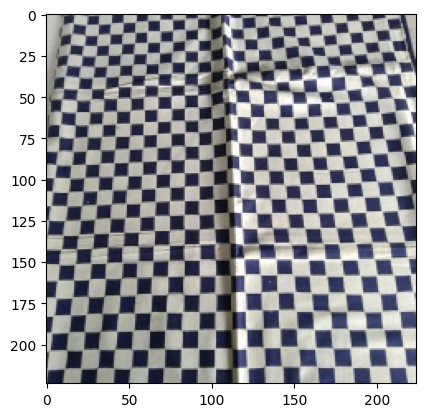

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = neural_net.predict(images, batch_size=10)
  print(classes.argmax())